# Sentiment Analysis of Real-time Flipkart Product


# Importing the libraries

In [97]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import joblib
import os
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score,make_scorer, precision_score,f1_score,confusion_matrix, classification_report
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from joblib import Memory
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

## Importing the dataset

In [3]:
df = pd.read_csv(r"C:\Users\india\My Python Files\INTERNSHIP\reviews_data_dump\reviews_badminton\data.csv")

In [5]:
df.shape

(8518, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [7]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [16]:
# filling nan values
df['Review text'].fillna(df['Review text'].mode()[0],inplace=True)

In [12]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

0

## Data Preprocessing 

In [17]:
df["Review text"]

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
                              ...                        
8509    Not sure why we have charged for this product ...
8510                                        GoodREAD MORE
8512                                        GoodREAD MORE
8513                                        GoodREAD MORE
8515                                        GoodREAD MORE
Name: Review text, Length: 8514, dtype: object

In [21]:
df["Review text"].apply(lambda x:True if emoji.emoji_count(x)>0 else False).sum()

287

In [20]:
df['Review text'][66]

'3rd class quality  I want Returns but time is overREAD MORE'

In [22]:
df['Review text'] = df['Review text'].str.replace('READ MORE', '')

In [23]:
def text_preprocessing(x):
    x = x.lower()  # converting entire text to lowercase
    x = emoji.demojize(x).replace(':', ' ')  # emoji prediction
    x = re.sub(r'www.\S+|https?://\S+', '', x)  # removing urls
    x = re.sub(r'<[^>]+>', '', x)  # removing html
    x = re.sub(r'[^a-zA-Z0-9]', ' ', x)
    x = re.sub(r'[0-9]', ' ', x)
    x = word_tokenize(x)
    x = [i for i in x if i not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    x = [lemmatizer.lemmatize(word) for word in x]
    return x

In [24]:
df['Review text'] =  df['Review text'].apply(text_preprocessing)

In [27]:
df['Review text'] = df['Review text'].apply(lambda x: ' '.join(x))

In [40]:
def review(x):
    if (x >= 3):
        return "Positive"
    else:
        return 'Negative'
df['Sentiment'] = df['Ratings'].apply(lambda x: review(x) )

<Axes: xlabel='Ratings', ylabel='count'>

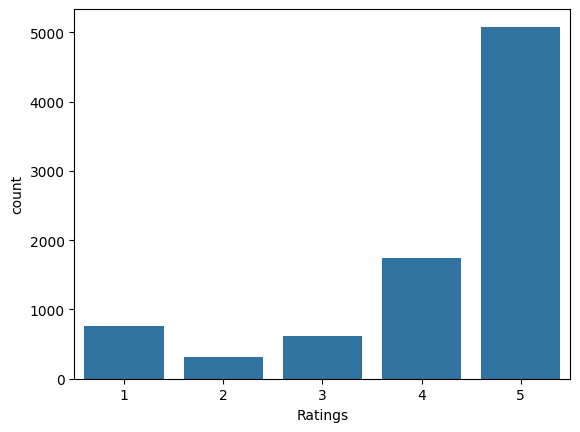

In [41]:
# plotting the rating data
sns.countplot(x='Ratings', data=df)

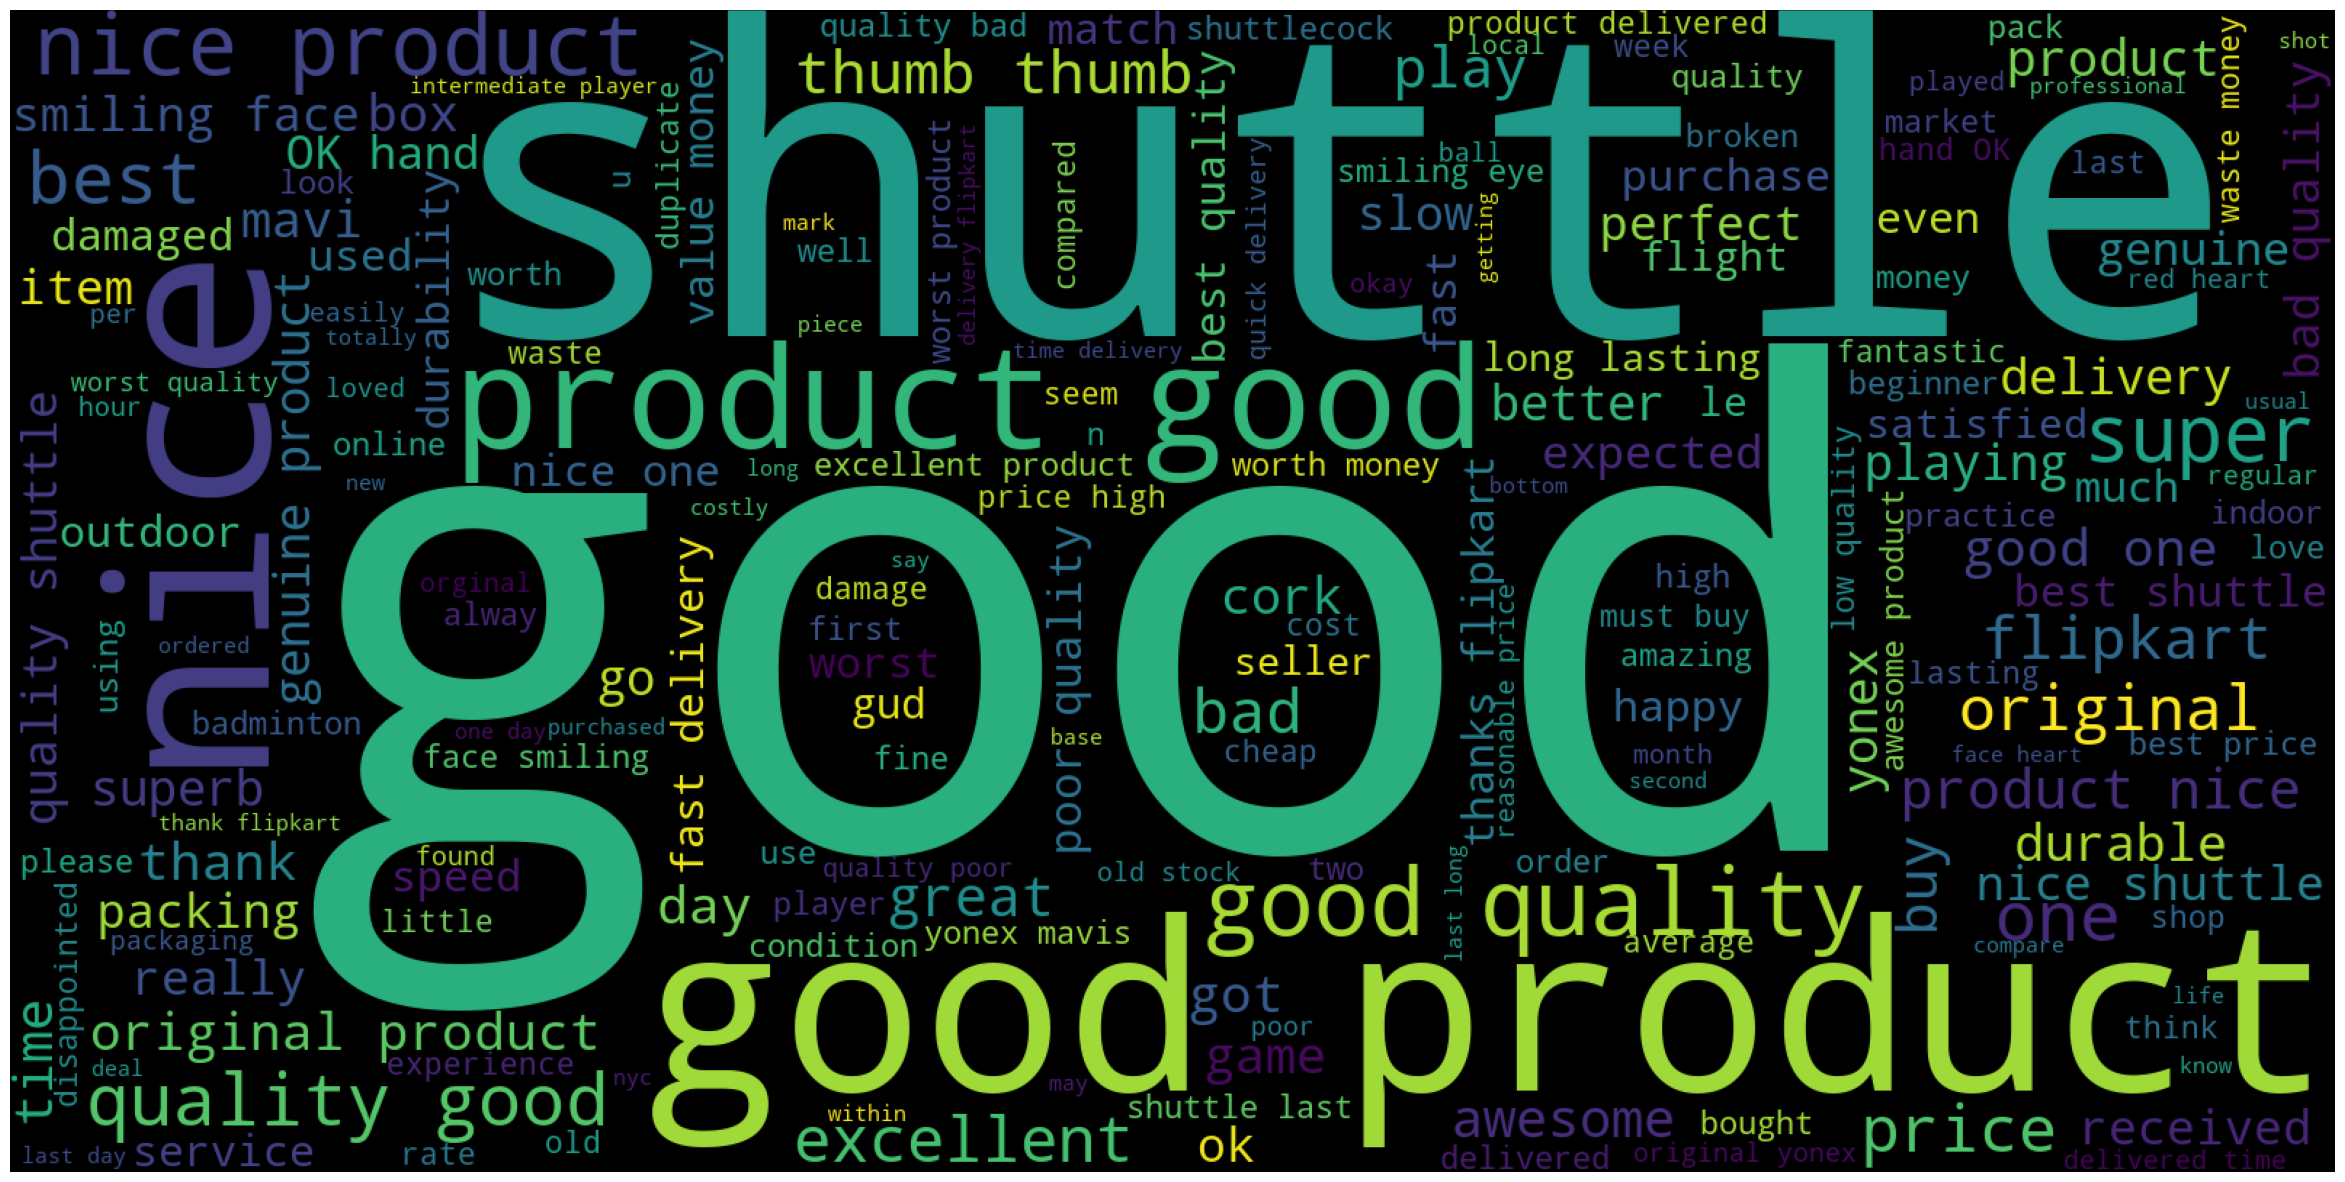

In [43]:
from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['Review text']))
plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

## Step 1 - Identify Input and Output

In [45]:
X = df['Review text']
y = df['sentiment']
print(X.shape, y.shape)

(8514,) (8514,)


## Step 2 - Split the Data into Train and Test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [47]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6811,) (6811,)
(1703,) (1703,)


## Step 3 - Data Preprocessing on X_train and X_test data

In [57]:
vect = CountVectorizer()
X_train_num = vect.fit_transform(X_train)
X_test_num = vect.transform(X_test)

## Step 4 - Building a Model (i.e. Train the classifier)

 #### for LogisticRegression

In [58]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train_num, y_train)

LogisticRegression()

In [59]:
y_train_pred = LR_model.predict(X_train_num)
y_pred=LR_model.predict(X_test_num)

In [61]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9254257193188491
              precision    recall  f1-score   support

    Negative       0.76      0.57      0.65       208
    Positive       0.94      0.98      0.96      1495

    accuracy                           0.93      1703
   macro avg       0.85      0.77      0.80      1703
weighted avg       0.92      0.93      0.92      1703



In [62]:
train_score=accuracy_score(y_train,y_train_pred)
test_score=accuracy_score(y_pred,y_test)
print(train_score)
print(test_score)

0.9412714726178241
0.9254257193188491


#### with Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier()
RF_model.fit(X_train_num, y_train)

RandomForestClassifier()

In [64]:
y_train_pred = RF_model.predict(X_train_num)
y_pred=LR_model.predict(X_test_num)

In [69]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9254257193188491
              precision    recall  f1-score   support

    Negative       0.76      0.57      0.65       208
    Positive       0.94      0.98      0.96      1495

    accuracy                           0.93      1703
   macro avg       0.85      0.77      0.80      1703
weighted avg       0.92      0.93      0.92      1703



#### with Naive Bayes

In [70]:
nb= MultinomialNB()
nb.fit(X_train_num,y_train)

MultinomialNB()

In [71]:
y_train_pred = nb.predict(X_train_num)
train_score=accuracy_score(y_train,y_train_pred)
print(train_score)
print(y_train_pred)

0.9324621935104977
['Positive' 'Positive' 'Negative' ... 'Positive' 'Positive' 'Positive']


In [72]:
pred=nb.predict(X_test_num)
test_score=accuracy_score(pred,y_test)
print(test_score)
print(pred)

0.9213153258954786
['Positive' 'Positive' 'Negative' ... 'Positive' 'Positive' 'Positive']


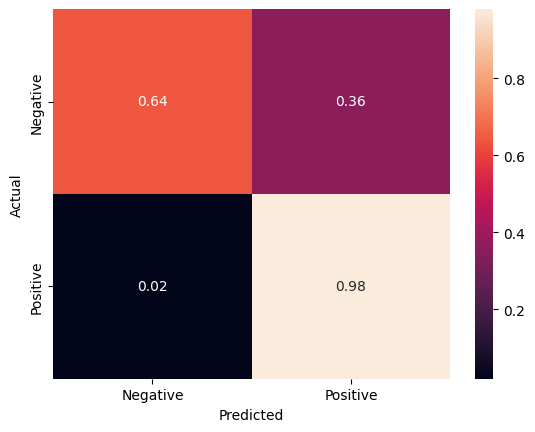

In [74]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
actual = np.sum(conf_matrix, axis=1).reshape(-1, 1)
conf_matrix_normalized = np.round(conf_matrix / actual, 2)
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [93]:
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', TfidfVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', TfidfVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__alpha' : [1, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__class_weight': ['balanced']
        }
    ],
    'decision_tree': [
        {
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
    
        }
    ]
}

# Assuming X_train and y_train are defined earlier
# Perform GridSearchCV for each algorithm

best_models = {}


# Update scoring parameter in GridSearchCV
for algo in pipelines.keys():
    print("*" * 10, algo, "*" * 10)
    grid_search = GridSearchCV(estimator=pipelines[algo],
                               param_grid=param_grids[algo],
                               cv=5,
                               scoring='f1',
                               return_train_score=True,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_models[algo] = grid_search.best_estimator_
    y_pred = grid_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label='Positive')
    print('F1 Score on Test Data:', f1)

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
F1 Score on Test Data: 0.9532648326151806
********** decision_tree **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
F1 Score on Test Data: 0.9495216100296933
********** logistic_regression **********
Fitting 5 folds for each of 48 candidates, totalling 240 fits
F1 Score on Test Data: 0.8582173749529898


In [94]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1000)),
                ('classifier', DecisionTreeClassifier())])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1000)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])



In [100]:
os.getcwd()

'C:\\Users\\india\\My Python Files\\INTERNSHIP'

In [102]:
save_dir = r'C:\\Users\\india\\My Python Files\\INTERNSHIP'

for name, model in best_models.items():
    print("*" * 10, name, "*" * 10)
    path = os.path.join(save_dir, f'{name}.pkl')

    try:
        joblib.dump(model, path)
        loaded_model = joblib.load(path)

        y_test_pred = loaded_model.predict(X_test)

        f1 = f1_score(y_test, y_test_pred, pos_label='Positive')

        print("F1 Score (Positive Class):", f1)
        print("Model Size:", os.path.getsize(path), "Bytes")
    except FileNotFoundError:
        print("Error: File not found at", path)
    except Exception as e:
        print("An error occurred:", e)

********** naive_bayes **********
F1 Score (Positive Class): 0.9532648326151806
Model Size: 76007 Bytes
********** decision_tree **********
F1 Score (Positive Class): 0.9495216100296933
Model Size: 149677 Bytes
********** logistic_regression **********
F1 Score (Positive Class): 0.8582173749529898
Model Size: 68682 Bytes
